# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загружаем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor

### Загружаем данные и смтрим общую информацию

In [2]:
try:
    df = pd.read_csv('F:\\autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
print(df.isna().sum())
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


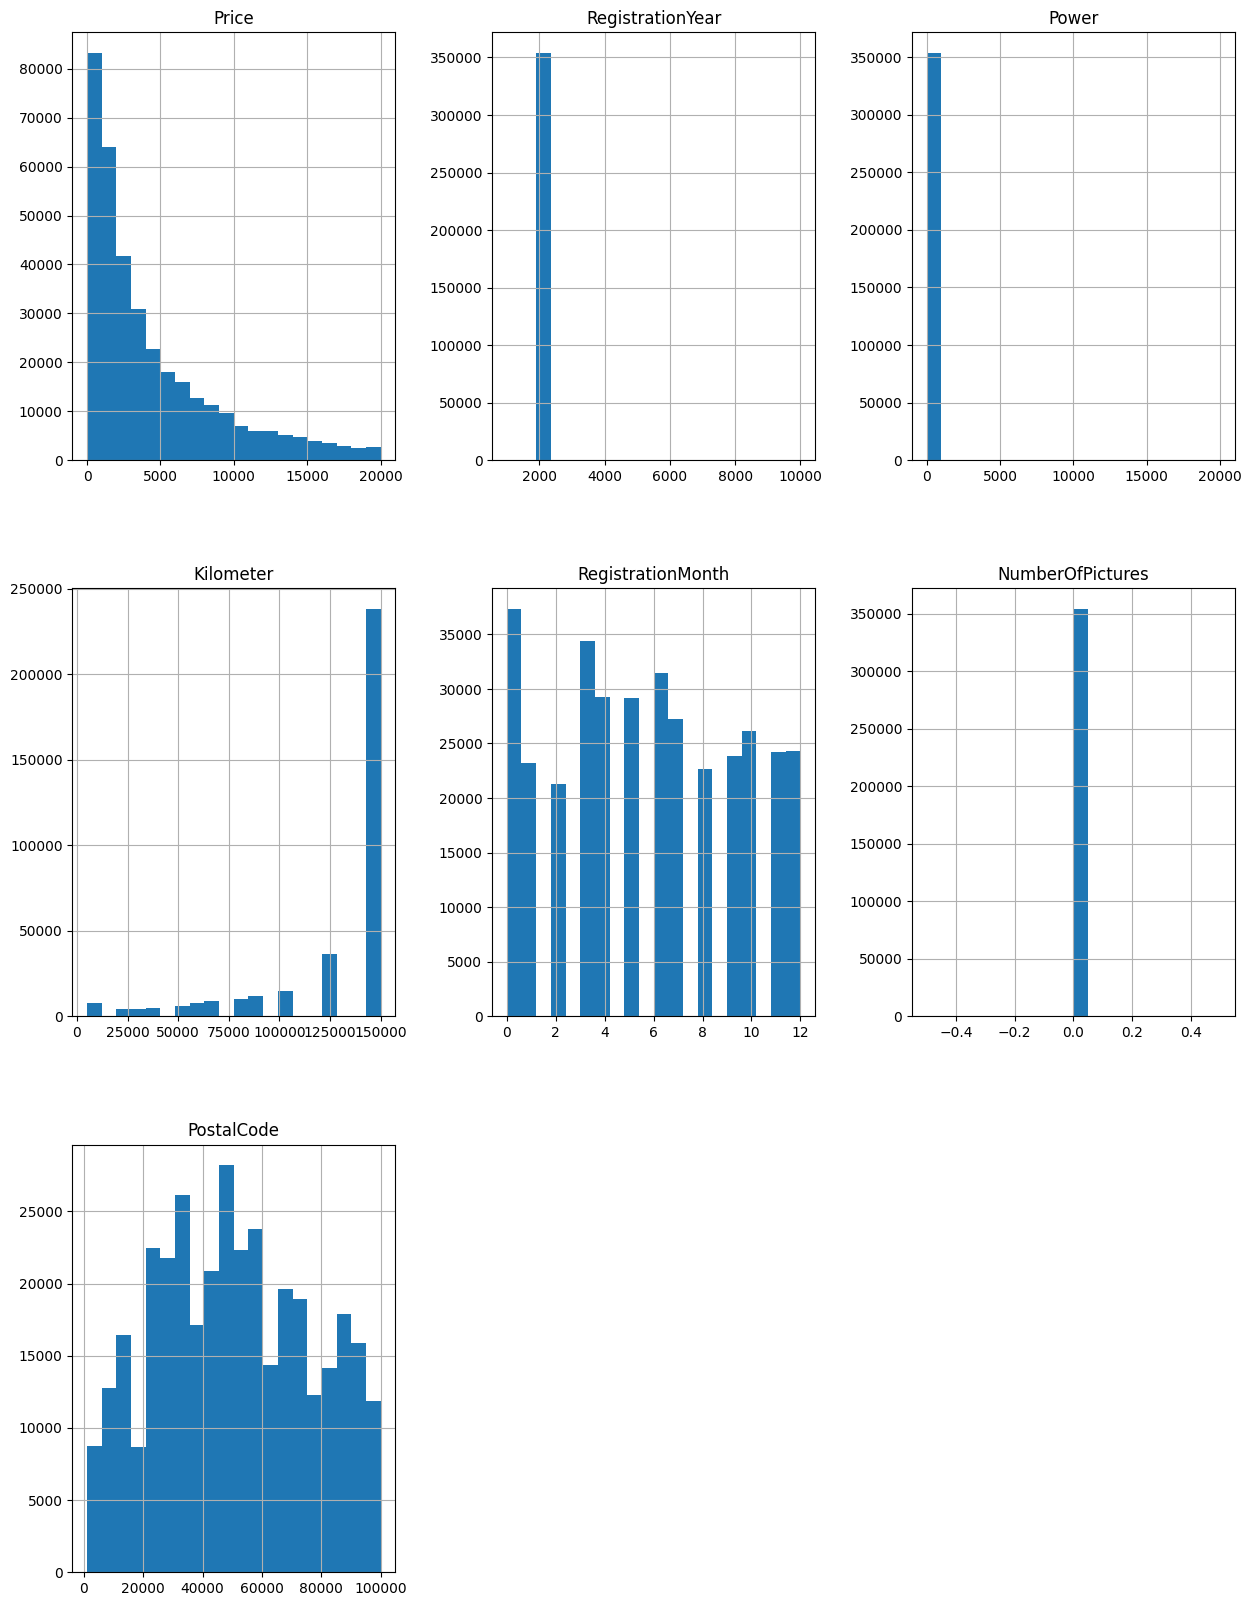

In [5]:
df.hist(figsize=(15, 20), bins=20);

Из общего анализа данных мы видим, что в данных присутствует очень много пропусков. В некоторых столбцах пропуски достигают 20%. Так же неоходимо некоторые столбцы привести в соответсвующий тип.

### Обработка данных

#### Приводим все название столбцов к нижнему регистру

In [7]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

#### Переводим столбцы в формат времени

In [7]:
df['datecrawled'] = df['datecrawled'].astype('datetime64[s]')
df['lastseen'] = df['lastseen'].astype('datetime64[s]')
df['datecreated'] = df['datecreated'].astype('datetime64[D]')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        316879 non-null  object        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            334536 non-null  object        
 5   power              354369 non-null  int64         
 6   model              334664 non-null  object        
 7   kilometer          354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           321474 non-null  object        
 10  brand              354369 non-null  object        
 11  repaired           283215 non-null  object        
 12  datecreated        354369 non-null  datetime64[ns]
 13  numberofpictures   354369 non-null  int64   

In [9]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


#### Работаем со столбцом цена

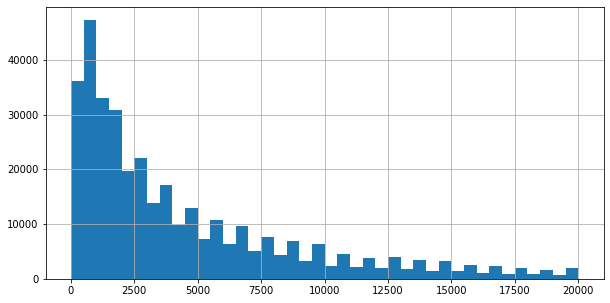

In [10]:
df['price'].hist(figsize=(10, 5), bins=40);

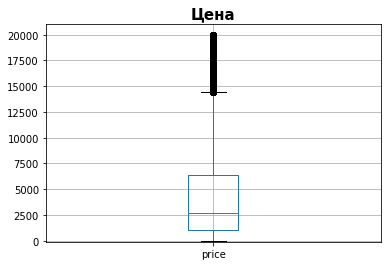

In [11]:
df['price'].plot(kind='box', grid=True)
plt.title('Цена', fontsize = 15, fontweight='bold')
plt.ylim(-100, 21000);

In [12]:
df[df['price']>14000]
df[df['price']<50]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32


In [13]:
df = df.query('price > 50')

In [14]:
df[df['price']<50]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen


В столбце с нашим целевым признаком, пропусков не было. При построении гистограммы мы видим, что много объектов находятся ближе к значению ноль. Объявления в которых цена ниже 50 евро, решено было убрать, так как данные объявления или фейк, или машина в разбитом состоянии. Цены, которые выше 15000 евро решено было оставить, так как это могут быть эксклюзивные машины, значительно отличающиеся стоимостью.

#### Работаем со столбцом модель

In [15]:
df.loc[df['model'].isna(), 'model'] = 'other'

In [16]:
df['model'].unique()
df.isna().sum()

datecrawled              0
price                    0
vehicletype          32844
registrationyear         0
gearbox              16547
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype             28578
brand                    0
repaired             64689
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Так как модель сложно с точностью определить, а для модели данные признаки важны, данные пропуски было решено заменить значением другое. Можно было бы заменить аналогичными значениями в других столбцах отталкиваясь от года регистрации и бренда машины, но точность была бы низкая в правильности указания, так как зарегистрировать машину могли в любое время новый хозяин. 

#### Работаем со столбцом тип кузова

In [17]:
df['vehicletype'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [18]:
df.loc[df['vehicletype'].isna(), 'vehicletype'] = 'other'

In [19]:
df['vehicletype'].unique()
df['vehicletype'].isna().sum()

0

В данном столбце пропуски были заменены на значение другое. Была мысль заменить значение отталкиваясь от модели машины. Но допустим в модели golf присутствуют почти все типы кузова, поэтому от этого способа было решено отказаться.

#### Работаем со столбцом тип год регистрации

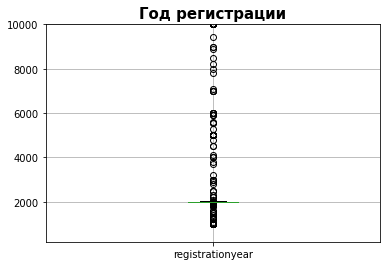

In [20]:
df['registrationyear'].plot(kind='box', grid=True)
plt.title('Год регистрации', fontsize = 15, fontweight='bold')
plt.ylim(200, 10000);

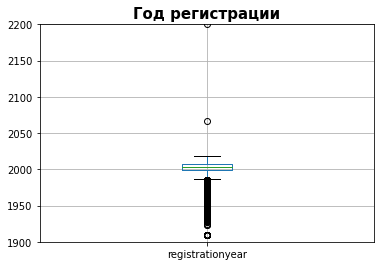

In [21]:
df['registrationyear'].plot(kind='box', grid=True)
plt.title('Год регистрации', fontsize = 15, fontweight='bold')
plt.ylim(1900, 2200);

In [22]:
df['registrationyear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 8000,
       5300, 9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934,
       1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

In [23]:
df['datecrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [24]:
df = df.query('registrationyear < 2016 & registrationyear > 1966')

In [25]:
df['registrationyear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2007, 2009,
       2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006, 1999, 2012,
       2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982, 1976, 1983,
       1973, 1969, 1971, 1987, 1986, 1988, 1980, 1970, 1974, 1979, 1978,
       1972, 1968, 1977, 1975, 1967])

В данных в регистрации автомобиля были аномалии. Владельцы видимо указывали просто набор данных в окошке дата. Так же были удаленны значения автомобилей старше 50 лет. Из выгрузки анкет видим, что данные были выгруженны до 2016, соответственно этот год мы ставим максимальным

#### Работаем со столбцом тип коробки передач

In [26]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [27]:
df.dropna(subset=['gearbox'], inplace=True)

In [28]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype              0
registrationyear         0
gearbox                  0
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype             14663
brand                    0
repaired             46640
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Так как выяснить какая коробка была на автомобиле почти, что не реально, мной было решено удалить данные с пропусками, так как общее количество пропусков от общего датасета состовляет 6 процентов.

#### Работаем со столбцом мощность

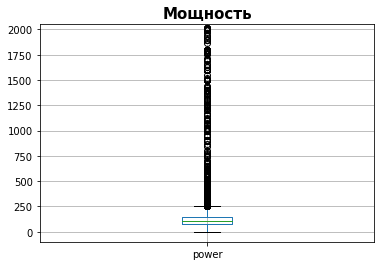

In [29]:
df['power'].plot(kind='box', grid=True)
plt.title('Мощность', fontsize = 15, fontweight='bold')
plt.ylim(-100, 2050);

In [30]:
df = df.query('power < 320 & power > 20')

Так как машины с объемом мощности свыше 320 почти не встречаются, то мной было решено удалить все машины у которых мощность свыше 320л.с. Так же были удалены машины мощностью менее 20л.с.

#### Работаем со столбцом тип топлива

In [31]:
df['fueltype'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [32]:
df.loc[df['fueltype'].isna(), 'fueltype'] = 'other'

In [33]:
df['fueltype'].unique()

array(['gasoline', 'petrol', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

Чтобы не терять данные, пропуски в тип топлево были заменены на другое.

#### Работаем со столбцом тип топлива

In [34]:
df['repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

In [35]:
df.loc[df['repaired'].isna(), 'repaired'] = 'no'

In [36]:
df['repaired'].unique()

array(['yes', 'no'], dtype=object)

В данном столбце данные решено было заменить на значение нет. Так как если человек решил не указывать был ли ремонт, то скорее всего для него этот параметр в заполнении был не важет, так как ремонта не было.

#### Итоговая обработка данных и подготовки их к обучению модели

In [37]:
df.drop(['datecrawled', 'registrationmonth', 'datecreated', 'postalcode', 'lastseen', 'numberofpictures'], axis=1, inplace=True)

Из датасета были удалены столбцы, которые незначимы для предсказания модели, такие как дата скачивания анкеты, почтовый индекс пользователя, так же был удален столбец количество фото, так как там было везде значение 0. Данные признаки могли наоборот негативно повлиять на модели, а так же на скорость предсказания и обучения модели.

In [38]:
df.drop_duplicates(inplace=True)

Из получившегося датасета, удаляем все дупликаты, что так же повлияет на скорость работы модели, не теряя качество.

In [39]:
df.head()
print(df.isna().sum())
df

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64


,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354357,1690,wagon,2004,manual,55,fabia,150000,petrol,skoda,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


#### Подготовка данных для модели

In [40]:
features = df.drop('price', axis=1)
target = df['price']

In [41]:
train_features, features_40, train_target, target_40 = \
train_test_split(features, target, test_size=0.40, random_state=12345)
test_features, valid_features, test_target, valid_target = \
train_test_split(features_40, target_40, test_size=0.50, random_state=12345)

In [42]:
train_features

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
183875,small,2002,manual,60,punto,125000,petrol,fiat,no
125980,small,2007,manual,64,polo,80000,petrol,volkswagen,no
280773,small,2000,manual,54,corsa,20000,petrol,opel,no
256654,wagon,2006,manual,192,5er,150000,petrol,bmw,no
247864,wagon,2001,auto,136,galaxy,150000,gasoline,ford,yes
...,...,...,...,...,...,...,...,...,...
115273,bus,2006,manual,115,sharan,150000,gasoline,volkswagen,no
185706,convertible,2006,manual,136,2_reihe,100000,petrol,peugeot,no
181257,small,1985,auto,75,golf,150000,petrol,volkswagen,yes
103532,sedan,2007,manual,116,a_klasse,80000,petrol,mercedes_benz,no


In [43]:
train_features = train_features.reset_index(drop=True)
valid_features = valid_features.reset_index(drop=True)
test_features = test_features.reset_index(drop=True)

In [44]:
print('Размер тренировочной выборки:', train_features.shape, train_target.shape)
print('Размер проверочной выборки:', valid_features.shape, valid_target.shape)
print('Размер тестовой выборки:', test_features.shape, test_target.shape)

Размер тренировочной выборки: (142479, 9) (142479,)
Размер проверочной выборки: (47493, 9) (47493,)
Размер тестовой выборки: (47493, 9) (47493,)


Делим данные на целевой признак и признаки. Так же делим данные на 3 части, на той которую будем модель обучать 60%, на проверочную 20% и тестовую 20%.

In [45]:
cat_col = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

In [46]:
encoder = OrdinalEncoder()
encoder.fit(train_features[cat_col])
features_ordinal_train = train_features
features_ordinal_train[cat_col] = pd.DataFrame(encoder.transform(train_features[cat_col]), columns=train_features[cat_col].columns)

In [47]:
encoder.fit(valid_features[cat_col])
features_ordinal_valid = valid_features
features_ordinal_valid[cat_col] = pd.DataFrame(encoder.transform(valid_features[cat_col]), columns=valid_features[cat_col].columns)

In [48]:
encoder.fit(test_features[cat_col])
features_ordinal_test = test_features
features_ordinal_test[cat_col] = pd.DataFrame(encoder.transform(test_features[cat_col]), columns=test_features[cat_col].columns)

Переводим категориальные признаки в количественные, для обучения модели.

In [49]:
corr = features_ordinal_train.corr()
corr

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
vehicletype,1.000000,0.051833,-0.041063,-0.018617,-0.146043,0.043837,-0.046188,-0.052071,0.027756
registrationyear,0.051833,1.000000,-0.038452,0.152847,-0.029176,-0.337062,-0.275805,-0.028093,-0.114046
gearbox,-0.041063,-0.038452,1.000000,-0.412549,0.041354,-0.040241,0.133699,0.093945,0.023619
power,-0.018617,0.152847,-0.412549,1.000000,-0.129136,0.131102,-0.202756,-0.315126,-0.056029
model,-0.146043,-0.029176,0.041354,-0.129136,1.000000,-0.031844,-0.026376,0.450922,0.009569
kilometer,0.043837,-0.337062,-0.040241,0.131102,-0.031844,1.000000,-0.171086,-0.058741,0.087851
fueltype,-0.046188,-0.275805,0.133699,-0.202756,-0.026376,-0.171086,1.000000,0.027570,0.030638
brand,-0.052071,-0.028093,0.093945,-0.315126,0.450922,-0.058741,0.027570,1.000000,-0.002957
repaired,0.027756,-0.114046,0.023619,-0.056029,0.009569,0.087851,0.030638,-0.002957,1.000000


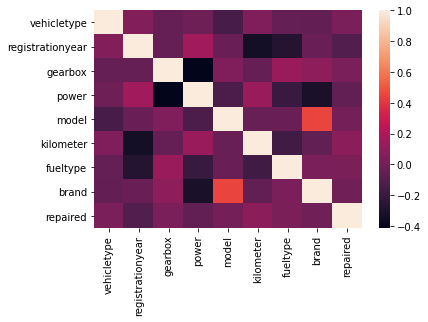

In [50]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns);

Видим что наиболее коррелируют между собой бранд и модель, что и понятно, так как у определенного бренда идут свои модели. Отрицательная корреляция наблюдается от мощности и типа коробки. Из данных мы не наблюдаем сильной корреляции признаков, а только умеренную.

**Вывод**

На данном этапе мы максимально очистили данные от выбросов, таких как цена слишком маленькая и слишком большая, мощности машины. Так же на данном этапе мы максимально постарались заполнить пропуски. А там где не возможно было заполнить пропуски, удалили. Были разделены выборки на три части, обучающую, проверочную и тестовую.

## Обучение моделей

### Пишем функцию для подсчета RMSE

In [51]:
def rmse(target, predict):
    rmse = ((mean_squared_error(target, predict))**0.5).round(2)
    return rmse

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

### Обучение модели линейной регрессии

In [52]:
%%time
start = time.time()
model_lr=LinearRegression()
model_lr.fit(features_ordinal_train, train_target)
end = time.time()
t_lr=round(end-start,2)

CPU times: user 38.3 ms, sys: 3.75 ms, total: 42 ms
Wall time: 45.7 ms


In [53]:
%%time
start = time.time()
predict_lr=model_lr.predict(features_ordinal_valid)
end = time.time()
t_lr_p=round(end-start,2)

CPU times: user 22.8 ms, sys: 36.2 ms, total: 59 ms
Wall time: 25.8 ms


In [54]:
rmse_lr=(mean_squared_error(valid_target, predict_lr))**0.5
print('RMSE модели Линейная Регрессия равна:', rmse_lr.round(2))

RMSE модели Линейная Регрессия равна: 2889.51


### Обучаем и ищем лучшие параметры для модели леса

In [55]:
rfr = RandomForestRegressor()

In [56]:
parametrs = {'n_estimators': range (10, 150, 10),
            'max_depth': range (1, 10, 2)}

In [57]:
grid_rfr = GridSearchCV(rfr, param_grid = parametrs, scoring = rmse_scorer, cv=2)
grid_rfr.fit(features_ordinal_train, train_target)

GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 10, 2),
                         'n_estimators': range(10, 150, 10)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [58]:
grid_rfr.best_params_

{'max_depth': 9, 'n_estimators': 120}

In [59]:
grid_rfr.best_score_

-1913.27

### Обучаем и ищем лучшие параметры для модели кота

In [60]:
cb = CatBoostRegressor()

In [61]:
parametrs_cb = {'max_depth': range (1, 13, 2),
            'iterations' : [50, 100, 150, 250, 300]}

In [62]:
grid_cb = GridSearchCV(cb, param_grid = parametrs_cb, scoring = rmse_scorer, cv=2)
grid_cb.fit(features_ordinal_train, train_target, verbose=50)

Learning rate set to 0.5
0:	learn: 3850.8487994	total: 66.1ms	remaining: 3.24s
49:	learn: 2312.0259718	total: 354ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3874.0829655	total: 7.41ms	remaining: 363ms
49:	learn: 2335.1537369	total: 304ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3436.2922998	total: 8.66ms	remaining: 424ms
49:	learn: 1816.6242319	total: 423ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3456.3001173	total: 7.25ms	remaining: 355ms
49:	learn: 1838.6815167	total: 404ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3317.5936160	total: 10ms	remaining: 490ms
49:	learn: 1686.0206974	total: 497ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3327.6009717	total: 8.57ms	remaining: 420ms
49:	learn: 1713.2432868	total: 494ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3210.7393876	total: 17.4ms	remaining: 853ms
49:	learn: 1598.6010216	total: 730ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3226.3992144	total: 14.2ms	remaining: 697ms
49:	le

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f840b8ce5b0>,
             param_grid={'iterations': [50, 100, 150, 250, 300],
                         'max_depth': range(1, 13, 2)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [63]:
grid_cb.best_params_

{'iterations': 300, 'max_depth': 9}

In [64]:
grid_cb.best_score_

-1600.2600000000002

### Обучаем и ищем лучшие параметры для модели ЛГБМ

In [65]:
parametrs_lgbm = {'n_estimators': range [50, 100, 150],
            'max_depth': range (10, 13, 1)}

In [66]:
lgbm = LGBMRegressor()

In [67]:
grid_lgbm = GridSearchCV(lgbm, param_grid = parametrs_lgbm, scoring = rmse_scorer, cv=2)
grid_lgbm.fit(features_ordinal_train, train_target)

GridSearchCV(cv=2, estimator=LGBMRegressor(),
             param_grid={'max_depth': range(1, 16, 4),
                         'n_estimators': range(50, 150, 50)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [68]:
grid_lgbm.best_params_

{'max_depth': 13, 'n_estimators': 100}

In [69]:
grid_lgbm.best_score_

-1678.815

**Вывод**

В данном разделе нашел модели с лучшими параметрами для дальнейщего анализа. Модель леса будем анализировать с параметрами глубиной леса 9, количеством деревьев 140. Модель кота будем анализировать глубиной 9 и итерациями 300. Модель ЛГБМ будем тестировать с количеством оценщиков и клубиной . Модель линейной регрессии показала себя плохо для данной задачи, рмсе у нее больше 2500, что уже не подходит для дальнейшего анализа данной модели.

## Анализ моделей

### Считаем время для обучения и предсказания для каждой модели

#### Для модели леса

In [70]:
%%time
start = time.time()
model_rfr=RandomForestRegressor(n_estimators=120, max_depth=9, random_state=12345)
model_rfr.fit(features_ordinal_train, train_target)
end = time.time()
t_rfr=round(end-start,2)

CPU times: user 9.64 s, sys: 2.4 ms, total: 9.64 s
Wall time: 9.64 s


In [71]:
%%time
start = time.time()
predict_rfr=model_rfr.predict(features_ordinal_valid)
end = time.time()
t_rfr_p=round(end-start,2)

CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 211 ms


In [72]:
rmse_rfr=(mean_squared_error(valid_target, predict_rfr))**0.5
print('RMSE модели леса:', rmse_rfr.round(2))

RMSE модели леса: 1930.49


#### Для модели кота

In [73]:
%%time
start = time.time()
model_cb=CatBoostRegressor(iterations=300, max_depth=9, random_state=12345)
model_cb.fit(features_ordinal_train, train_target)
end = time.time()
t_cb=round(end-start,2)

Learning rate set to 0.238546
0:	learn: 3877.7654528	total: 27.7ms	remaining: 8.29s
1:	learn: 3309.5862432	total: 55.2ms	remaining: 8.23s
2:	learn: 2901.6824289	total: 89ms	remaining: 8.81s
3:	learn: 2607.9277500	total: 118ms	remaining: 8.74s
4:	learn: 2398.5513583	total: 145ms	remaining: 8.54s
5:	learn: 2249.9572923	total: 176ms	remaining: 8.61s
6:	learn: 2149.1387360	total: 201ms	remaining: 8.42s
7:	learn: 2064.9730623	total: 228ms	remaining: 8.34s
8:	learn: 2011.1736755	total: 256ms	remaining: 8.26s
9:	learn: 1968.2910047	total: 282ms	remaining: 8.18s
10:	learn: 1930.1189335	total: 307ms	remaining: 8.07s
11:	learn: 1892.1518487	total: 336ms	remaining: 8.05s
12:	learn: 1861.1365693	total: 372ms	remaining: 8.21s
13:	learn: 1841.1663697	total: 395ms	remaining: 8.07s
14:	learn: 1827.5337011	total: 420ms	remaining: 7.98s
15:	learn: 1807.4527052	total: 453ms	remaining: 8.05s
16:	learn: 1793.5559322	total: 485ms	remaining: 8.08s
17:	learn: 1780.5193271	total: 511ms	remaining: 8.01s
18:	lea

In [74]:
%%time
start = time.time()
predict_cb=model_cb.predict(features_ordinal_valid)
end = time.time()
t_cb_p=round(end-start,2)

CPU times: user 51.4 ms, sys: 0 ns, total: 51.4 ms
Wall time: 49.7 ms


In [75]:
rmse_cb=(mean_squared_error(valid_target, predict_cb))**0.5
print('RMSE модели кота:', rmse_cb.round(2))

RMSE модели кота: 1628.58


#### Для модели лгбм

In [80]:
%%time
start = time.time()
model_lgbm=LGBMRegressor(max_depth=13, n_estimators=100, random_state=12345)
model_lgbm.fit(features_ordinal_train, train_target)
end = time.time()
t_lgbm=round(end-start,2)

CPU times: user 6min 31s, sys: 4.28 s, total: 6min 35s
Wall time: 6min 37s


In [82]:
%%time
start = time.time()
predict_lgbm=model_lgbm.predict(features_ordinal_valid)
end = time.time()
t_lgbm_p=round(end-start,2)

CPU times: user 413 ms, sys: 3.82 ms, total: 417 ms
Wall time: 342 ms


In [83]:
rmse_lgbm=(mean_squared_error(valid_target, predict_lgbm))**0.5
print('RMSE модели лгбм:', rmse_lgbm.round(2))

RMSE модели лгбм: 1711.59


In [94]:
table = pd.DataFrame({'Лес':[t_rfr, t_rfr_p, rmse_rfr],
        'Кот':[t_cb, t_cb_p, rmse_cb],
        'ЛГБМ':[t_lgbm, t_lgbm_p, rmse_lgbm]})
table.index = ['Время обучения', 'Время предсказаний', 'РМСЕ']
table

,Лес,Кот,ЛГБМ
Время обучения,9.640000,9.250000,397.930000
Время предсказаний,0.210000,0.050000,0.340000
РМСЕ,1930.490837,1628.576485,1711.590307


**Вывод**

Наилучший результат как по времени так и по предсказаниям показала модель кота. Наихудший вариант по времени показала модель лгбм, в то время как по RMSE наихучшей оказалась модель леса

### Тестируем лучшую модель

In [95]:
%%time
start = time.time()
predict_test=model_cb.predict(features_ordinal_test)
end = time.time()
t_test_p=round(end-start,2)

CPU times: user 52.4 ms, sys: 0 ns, total: 52.4 ms
Wall time: 50.3 ms


In [96]:
rmse_cb=(mean_squared_error(test_target, predict_test))**0.5
print('RMSE модели кота:', rmse_cb.round(2))

RMSE модели кота: 1643.52


## Общий вывод

**В ходе исследования**

1. Изучил датасет на наличие пропусков, подготовили данные дальнейщего исследования
- Привел данные времени в нужный нам формат
- В целевом признаке цена, убрал цены, которые были ниже 50 евро, так как это машины либо для продажи на разбор, или фейковые объявления.
- Пропуски в столбцах модель, тип кузова, тип топлива заменил на other так как, эти данные необходимы для дальнейщего обучения модели, а заменить нет возможности, на наиболее правильное значение.
- В год регистрации машины были удаленны все выбросы которые были свыше 2016, так как анкеты были выгруженны до этого времени, так же были взяты машины не старше 50лет. Так как это уже металлолом, или реставрация, но рестоврация встречается очень редко.
- Пропуски в столбце механики были удалены, так как невозможно определить тип трансмиссии, что в дальнейщем может повлиять на предсказания, так как это один из вожных признаков.
- По мощности решил оставить машины от 20 до 320, так как мощность меньше не реальна, а мощность свыше 320 встречается редко.
- Поделены данные на обучающую, проверяющую и тестовые выборки, размерами 60-20-20, что является наиболее оптимальным вариантом.
- Были удалены столбцы с регистрацией анкеты, месяцем регистрации, почтовым индексом, количеством фото(так как там были только нули), данные столбцы, повлияли на время обучения, и в тоже время испортили качество модели.
- Категориальные признаки были переведены в численные.
2. Были обучены и найдены наилучшие параметры у 4 моделей, линейной регрессии, леса, кота, лгбм.
3. Было проведен анализ, где сравнили время обучения и качество предсказаний 3 моделей.
4. Проверили качество на тестовой выборке.


**Из исследования получены результаты:**

1. Модель линейной регрессии на этапе обучения мы сразу исключили, так как ее показания рмсе были выше 2500, а именно 2889.
2. Было выделено 3 модели у которых значение рмсе нас удовлетворяло. Эти модели леса, кота, лгбм. 
- На модели леса лучшие параметры оказались глубина 9 и количество деревьев 120.
- Модель кота лучшие параметры глубина 9, итераций 300
- Модель лгбм 100 итераций с глубиной 13
3. При проверке лучших моделей на проверочной выборке время обучения и показатели рмсе оказались:
- Модель леса время обучения 9.6с, время предсказания 0.21с, RMSE 1930
- Модель кота время обучения 9.25с, время предсказания 0.05с, RMSE 1628
- Модель лгбм время обучения 398с, время предсказания 0.34с, RMSE 1711
4. Из моделей было решено в дальнейшем работать с моделью кота, на тестовой выборке рмсе показало 1643, скорость предсказания 0.05c.

**Общие рекомендации**

В данных оказалось очень много пропусков и выбросов. Стоит более тщательней проверять создание данных. Можно ввести в сервис функцию обязательного поля для заполнения. Так же стоит уделить внимание на выбросы, так как много нереальных значений, например таких как цена 0, или год регистрации машины 5555. Можно поставить огранечения в полях заполнения.
Рекоммендую использовать модель кота, так как в ней идет оптимальное время обучения и предсказания, в то время, так же RMSE наименьшее.